<a href="https://colab.research.google.com/github/dieineb/CNNBrainTumorXception/blob/main/XceptionPreTrainedBrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Dieine Bernieri Schiavon

UFCSPA - Universidade Federal de Ciências da Saúde de Porto Alegre

Informática Biomédica

dieineb@ufcspa.edu.br

https://github.com/dieineb

03/2023

#**Feature extraction with a pretrained model**
Feature extraction consists of using the representations learned by a previously
trained model to extract interesting features from new samples. These features are
then run through a new classifier, which is trained from scratch.

**Dataset: Hamada, A. Br35H Brain Tumor Detection 2020. Dataset available online: www.kaggle.com/ahmedhamada0/brain-tumor-detection 


**Let's instantiate the Xception model:**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Data Loading**

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
 "/content/gdrive/MyDrive/Model/newdataBr35H/train",
 image_size=(299, 299),
 batch_size=32)
validation_dataset = image_dataset_from_directory(
 "/content/gdrive/MyDrive/Model/newdataBr35H/val",
 image_size=(299, 299),
 batch_size=32)
test_dataset = image_dataset_from_directory(
 "/content/gdrive/MyDrive/Model/newdataBr35H/test",
 image_size=(299, 299),
 batch_size=32)


Found 2100 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 300 files belonging to 2 classes.


In [3]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [4]:
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt



In [7]:
!pip install tf-explain # to use pre trained

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.3 MB/s eta 0:00:00


In [8]:
#import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False,   # Because we intend to use our own densely connected classifier (with only two classes: Normal Pneumonia, we don’t need to include it.
    input_shape=(299, 299, 3))
 
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

The final feature map has shape (10, 10, 2048). That’s the feature map on top of which
we’ll stick a densely connected classifier.
At this point, there are two ways we could proceed:
* Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.
* Extend the model we have (model_base) by adding Dense layers on top, and run
the whole thing from end to end on the input data. This will allow us to use
data augmentation, because every input image goes through the convolutional
base every time it’s seen by the model. But for the same reason, this technique isfar more expensive than the first.

We’ll cover both techniques. Let’s walk through the code required to set up the firstone: recording the output of base_model on our data and using these outputs as inputsto a new model

#**FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION**

We’ll start by extracting features as NumPy arrays by calling the predict() method of the base_model on our training, validation, and testing datasets.
Let’s iterate over our datasets to extract the Xception features.

In [ ]:
import numpy as np
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.xception.preprocess_input(images)
    features = base_model.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 370ms/step


Importantly, predict() only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the Xception model expects inputs that are preprocessed with the function keras.applications.xception.preprocess_input, which scales pixel values to an appropriate range.

The extracted features are currently of shape (10, 10, 2048)

In [ ]:
train_features.shape

(2100, 10, 10, 2048)

In [ ]:
#import necessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow import keras 
from tensorflow.keras import layers

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

In [ ]:
inputs = keras.Input(shape=(10, 10, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(128)(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="/content/gdrive/MyDrive/teste/feature_extration.BT",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
train_features, train_labels,
epochs=20,
validation_data=(val_features, val_labels),
callbacks=callbacks)

Epoch 1/20
66/66 [==============================] - 4s 48ms/step - loss: 24.6190 - accuracy: 0.8195 - val_loss: 25.6104 - val_accuracy: 0.7900
Epoch 2/20
66/66 [==============================] - 2s 32ms/step - loss: 8.3354 - accuracy: 0.9095 - val_loss: 5.3274 - val_accuracy: 0.9267
Epoch 3/20
66/66 [==============================] - 2s 32ms/step - loss: 5.7974 - accuracy: 0.9395 - val_loss: 1.8414 - val_accuracy: 0.9683
Epoch 4/20
66/66 [==============================] - 1s 13ms/step - loss: 3.3676 - accuracy: 0.9576 - val_loss: 3.0523 - val_accuracy: 0.9467
Epoch 5/20
66/66 [==============================] - 2s 32ms/step - loss: 1.8281 - accuracy: 0.9667 - val_loss: 1.4459 - val_accuracy: 0.9833
Epoch 6/20
66/66 [==============================] - 2s 32ms/step - loss: 1.7268 - accuracy: 0.9714 - val_loss: 0.5773 - val_accuracy: 0.9883
Epoch 7/20
66/66 [==============================] - 2s 31ms/step - loss: 2.0129 - accuracy: 0.9733 - val_loss: 0.2783 - val_accuracy: 0.9900
Epoch 8/20


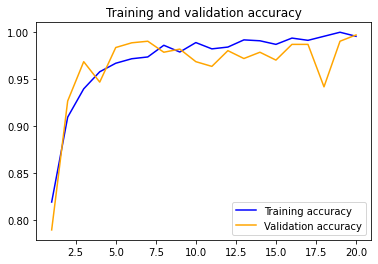

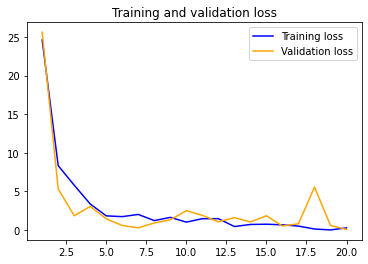

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "blue", label="Training accuracy")
plt.plot(epochs, val_acc, "orange", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "orange", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#**FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION**
Now let’s review the second technique I mentioned for doing feature extraction,
which is much slower and more expensive, but which allows us to use data augmenta-
tion during training: creating a model that chains the base_model with a new dense
classifier, and training it end to end on the inputs.
In order to do this, we will first freeze the convolutional base. Freezing a layer or set of
layers means preventing their weights from being updated during training. If we don’t
do this, the representations that were previously learned by the convolutional base will
be modified during training. Because the Dense layers on top are randomly initialized,
very large weight updates would be propagated through the network, effectively
destroying the representations previously learned.
In Keras, we freeze a layer or model by setting its trainable attribute to False.

#**Instantiating and freezing the Xception convolutional base**

In [9]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False)
base_model.trainable = False #Setting trainable to False empties the list of trainable weights of the layer or model.
 
base_model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [10]:
base_model.trainable = True
print ("This is the number of trainable weights "
"before freezing the conv base:", len(base_model.trainable_weights))

base_model.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(base_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 154
This is the number of trainable weights after freezing the conv base: 0



#Now we can create a new model that chains together

1 A data augmentation stage

2 Our frozen convolutional base

3 A dense classifier

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(299,299,3))
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
              metrics=["accuracy"])

With this setup, only the weights from the two Dense layers that we added will be
trained. That’s a total of four weight tensors: two per layer (the main weight matrix
and the bias vector). Note that in order for these changes to take effect, you must first
compile the model. If you ever modify weight trainability after compilation, you
should then recompile the model, or these changes will be ignored.
Let’s train our model. Thanks to data augmentation, it will take much longer for
the model to start overfitting, so we can train for more epochs—let’s do 50.
NOTE This technique is expensive enough that you should only attempt it if
you have access to a GPU (such as the free GPU available in Colab)—it’s
intractable on CPU. If you can’t run your code on GPU, then the previous
technique is the way to go.

In [15]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="/content/gdrive/MyDrive/teste/feature_extraction_with_data_augmentation.kerasBT",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
train_dataset,
epochs=30,
validation_data=validation_dataset,
callbacks=callbacks)

Epoch 1/30


66/66 [==============================] - ETA: 0s - loss: 34.3823 - accuracy: 0.7471

66/66 [==============================] - 344s 5s/step - loss: 34.3823 - accuracy: 0.7471 - val_loss: 6.2168 - val_accuracy: 0.9117
Epoch 2/30
66/66 [==============================] - 33s 491ms/step - loss: 13.8617 - accuracy: 0.8433 - val_loss: 6.8279 - val_accuracy: 0.8917
Epoch 3/30
66/66 [==============================] - 31s 472ms/step - loss: 10.5497 - accuracy: 0.8786 - val_loss: 13.5642 - val_accuracy: 0.8383
Epoch 4/30
66/66 [==============================] - ETA: 0s - loss: 7.4779 - accuracy: 0.8990

66/66 [==============================] - 60s 915ms/step - loss: 7.4779 - accuracy: 0.8990 - val_loss: 2.1864 - val_accuracy: 0.9517
Epoch 5/30
66/66 [==============================] - 33s 487ms/step - loss: 6.4501 - accuracy: 0.9100 - val_loss: 26.1459 - val_accuracy: 0.7267
Epoch 6/30
66/66 [==============================] - 31s 472ms/step - loss: 5.4641 - accuracy: 0.9243 - val_loss: 2.3689 - val_accuracy: 0.9583
Epoch 7/30
66/66 [==============================] - 31s 470ms/step - loss: 3.5821 - accuracy: 0.9348 - val_loss: 18.8478 - val_accuracy: 0.7683
Epoch 8/30
66/66 [==============================] - 32s 476ms/step - loss: 3.9374 - accuracy: 0.9229 - val_loss: 10.7912 - val_accuracy: 0.8233
Epoch 9/30
66/66 [==============================] - ETA: 0s - loss: 2.9626 - accuracy: 0.9343

66/66 [==============================] - 60s 913ms/step - loss: 2.9626 - accuracy: 0.9343 - val_loss: 0.7745 - val_accuracy: 0.9600
Epoch 10/30
66/66 [==============================] - 32s 483ms/step - loss: 2.4860 - accuracy: 0.9338 - val_loss: 0.8274 - val_accuracy: 0.9717
Epoch 11/30
66/66 [==============================] - 32s 475ms/step - loss: 1.9723 - accuracy: 0.9433 - val_loss: 27.9174 - val_accuracy: 0.6450
Epoch 12/30
66/66 [==============================] - ETA: 0s - loss: 1.4834 - accuracy: 0.9510

66/66 [==============================] - 61s 918ms/step - loss: 1.4834 - accuracy: 0.9510 - val_loss: 0.4866 - val_accuracy: 0.9717
Epoch 13/30
66/66 [==============================] - ETA: 0s - loss: 1.4726 - accuracy: 0.9529

66/66 [==============================] - 60s 916ms/step - loss: 1.4726 - accuracy: 0.9529 - val_loss: 0.3670 - val_accuracy: 0.9783
Epoch 14/30
66/66 [==============================] - 32s 480ms/step - loss: 1.2234 - accuracy: 0.9524 - val_loss: 0.4323 - val_accuracy: 0.9683
Epoch 15/30
66/66 [==============================] - 31s 470ms/step - loss: 0.9702 - accuracy: 0.9519 - val_loss: 0.5996 - val_accuracy: 0.9633
Epoch 16/30
66/66 [==============================] - 31s 468ms/step - loss: 0.9083 - accuracy: 0.9562 - val_loss: 0.7046 - val_accuracy: 0.9550
Epoch 17/30
66/66 [==============================] - ETA: 0s - loss: 0.8818 - accuracy: 0.9548

66/66 [==============================] - 60s 911ms/step - loss: 0.8818 - accuracy: 0.9548 - val_loss: 0.1201 - val_accuracy: 0.9833
Epoch 18/30
66/66 [==============================] - 32s 485ms/step - loss: 0.5200 - accuracy: 0.9695 - val_loss: 0.7003 - val_accuracy: 0.9467
Epoch 19/30
66/66 [==============================] - 31s 472ms/step - loss: 0.5143 - accuracy: 0.9614 - val_loss: 3.4264 - val_accuracy: 0.8217
Epoch 20/30
66/66 [==============================] - 31s 467ms/step - loss: 0.2924 - accuracy: 0.9738 - val_loss: 0.1482 - val_accuracy: 0.9817
Epoch 21/30
66/66 [==============================] - 31s 473ms/step - loss: 0.2250 - accuracy: 0.9748 - val_loss: 4.8287 - val_accuracy: 0.7600
Epoch 22/30
66/66 [==============================] - 32s 472ms/step - loss: 0.2488 - accuracy: 0.9700 - val_loss: 0.1259 - val_accuracy: 0.9800
Epoch 23/30
66/66 [==============================] - 31s 468ms/step - loss: 0.2480 - accuracy: 0.9719 - val_loss: 0.7125 - val_accuracy: 0.9200
Epoc

66/66 [==============================] - 60s 908ms/step - loss: 0.0819 - accuracy: 0.9843 - val_loss: 0.0506 - val_accuracy: 0.9883
Epoch 29/30
66/66 [==============================] - 32s 480ms/step - loss: 0.0936 - accuracy: 0.9810 - val_loss: 0.2373 - val_accuracy: 0.9550
Epoch 30/30
66/66 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9800

66/66 [==============================] - 60s 911ms/step - loss: 0.1039 - accuracy: 0.9800 - val_loss: 0.0362 - val_accuracy: 0.9933


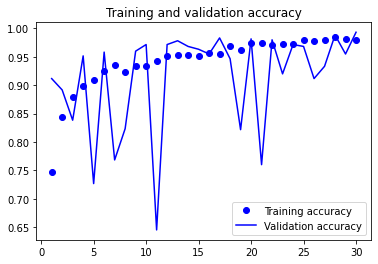

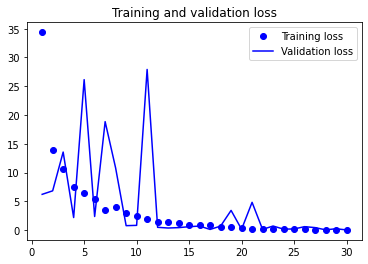

In [18]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
test_model = keras.models.load_model(
"/content/gdrive/MyDrive/teste/feature_extraction_with_data_augmentation.kerasBT")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

10/10 [==============================] - 52s 559ms/step - loss: 1.0079 - accuracy: 0.9233
Test accuracy: 0.9233


#**Test accuracy: 92.33%**

#**Reference:**
Deep Learning With Python [François Chollet, 2021] - Second Edition
Introduction to deep learningfor computer vision Cap.8